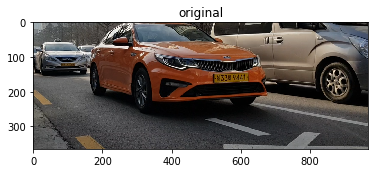

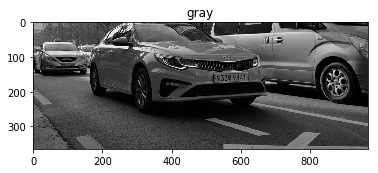

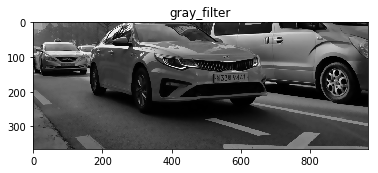

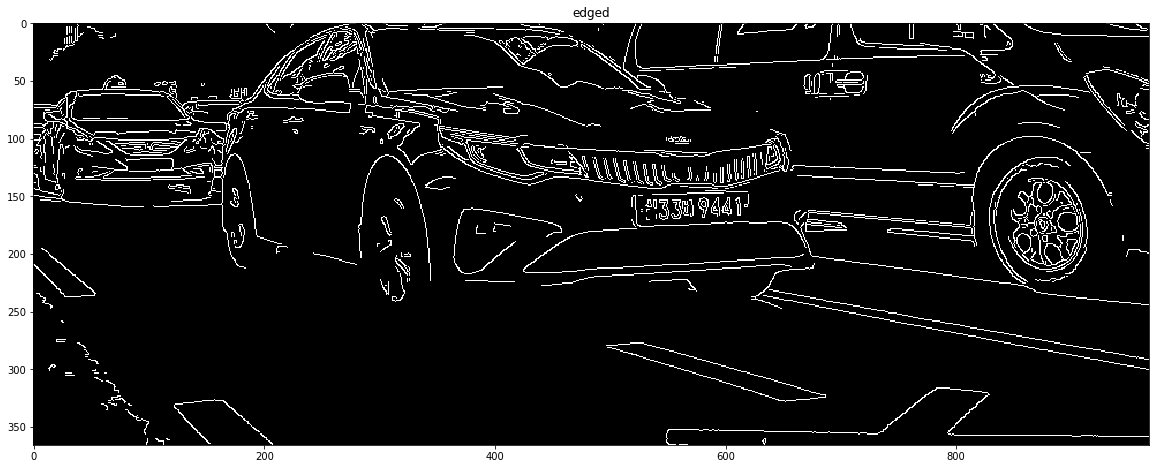

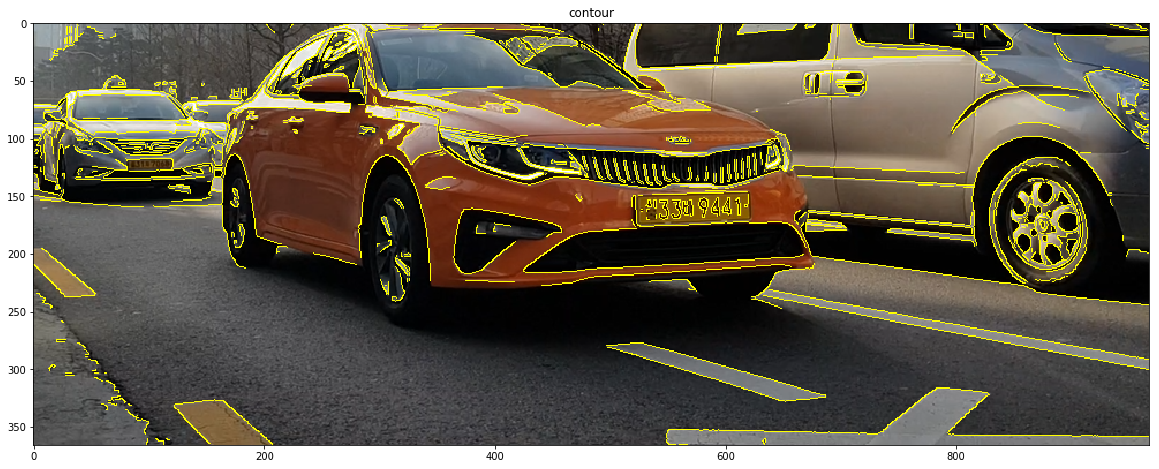

Texts:

"333바 9441
"

"333"

"바"

"9441"


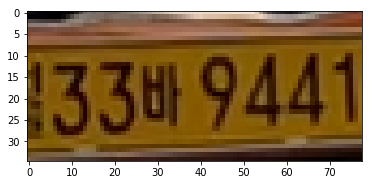

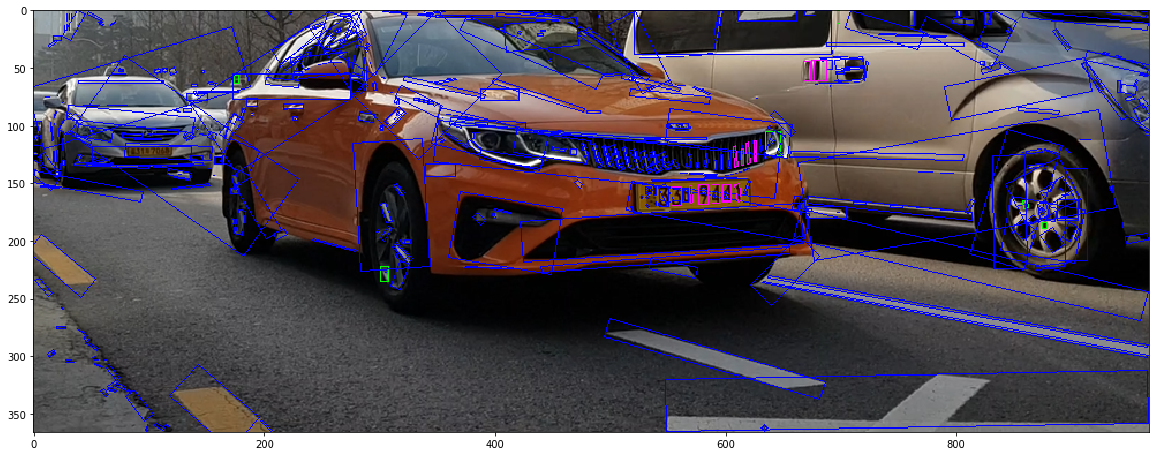

In [12]:
import os
json_path = '1575100358635-7a9ef19616a3.json'
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = json_path

def detect_text(path):
    """Detects text in the file."""
    from google.cloud import vision
    import io
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()

    image = vision.types.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    print('Texts:')

    for text in texts:
        print('\n"{}"'.format(text.description))

#         vertices = (['({},{})'.format(vertex.x, vertex.y)
#                     for vertex in text.bounding_poly.vertices])

#         print('bounds: {}'.format(','.join(vertices)))
        
import cv2
import numpy as np
import matplotlib.pyplot as plt

#################### DATA PREPROCESS ######################
img = cv2.imread('img/test4.jpg')
img_copy = img.copy()
img_copy2 = img.copy()
# RGB to Gray scale conversion
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# Noise removal with iterative bilateral filter(removes noise while preserving edges)
gray_filter = cv2.bilateralFilter(gray, 11, 17, 17)
# Find Edges of the grayscale image
edged = cv2.Canny(gray_filter, 150, 200)

# 컨투어 추출
_, extracted_contours, hierachy = cv2.findContours(edged, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(img_copy, extracted_contours,-1,(0,255,255),1)

plt.title('original'),plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB)),plt.show()
plt.title('gray'),plt.imshow(gray,cmap='gray'),plt.show()
plt.title('gray_filter'),plt.imshow(gray_filter,cmap='gray'),plt.show()
plt.figure(figsize=(20,20))
plt.title('edged'),plt.imshow(edged,cmap='gray'),plt.show()
plt.figure(figsize=(20,20))
plt.title('contour'),plt.imshow(cv2.cvtColor(img_copy,cv2.COLOR_BGR2RGB)),plt.show()

###################### ALGORITHM START ####################### 
def check_rect(rect):
    minArea = 20
    maxArea = 1000
    ratioMin = 0.05
    ratioMax = 0.8
    (x, y), (width, height), rect_angle = rect
    # angle preprocess
    if (width > height):
        angle = -rect_angle
    else:
        angle = 90 + rect_angle
    # 앵글이 80도 이하면 False
    if angle < 80:
        return False    
    #rect 넓이 저장
    area = width*height
    #ratio 범위 1:0.05 ~ 1:0.8
    try:
        ratio = float(width)/float(height)
    except:
        pass
    # 범위밖 이거나, 비율이 다를경우 False 리턴
    if (area < minArea or area > maxArea) or (ratio < ratioMin or ratio > ratioMax):
        return False
    return True

chk = False

RECT = []
for i,cnts in enumerate(extracted_contours):
    min_rect = cv2.minAreaRect(cnts)
    box = cv2.boxPoints(min_rect)
    box = np.int0(box)
    cv2.drawContours(img,[box],0,(255,0,0),1)
    # 컨투어를 둘러싸는 박스 찾기
    if check_rect(min_rect):
        RECT.append(min_rect)
        box = cv2.boxPoints(min_rect)
        box = np.int0(box)
        cv2.drawContours(img,[box],0,(0,255,0),1)
        x, y, w, h = cv2.boundingRect(cnts)
        chk = True

# 찾은 모든 RECT를 기준으로
# y값의 차이가 0~2 픽셀이며, x값의 차이가 0~20인 픽셀인 rect의 좌표가 존재한다면 count를 올린다
cnt_lst = []
for i in range(len(RECT)):
    cnt = 0
    delta_x = RECT[i][0][0]
    delta_y = RECT[i][0][1]
    for j in range(len(RECT)):
        if (abs(delta_x-RECT[j][0][0]) < 20)and(abs(delta_y-RECT[j][0][1]) < 2):
            if (delta_x!=RECT[j][0][0]) and (delta_x!=RECT[j][0][1]):
                box = cv2.boxPoints(RECT[i])
                box = np.int0(box)
                cv2.drawContours(img,[box],0,(255,0,255),1)
                cnt+=1
    cnt_lst.append(cnt)
    
# count가 가장 높은(이웃이 가장많은) rect의 index를 찾는다
many_idx = cnt_lst.index(max(cnt_lst))
CorrectArea_x = RECT[many_idx][0][0]
CorrectArea_y = RECT[many_idx][0][1]
CorrectRect_lst = []
# 가장 많은 이웃을 가진 rect의 이웃들을 CorrectRect_lst에 정의.
for i in range(len(RECT)):
        if (abs(CorrectArea_x-RECT[i][0][0]) < 100)and(abs(CorrectArea_y-RECT[i][0][1]) < 10):
            if (CorrectArea_x!=RECT[i][0][0]) and (CorrectArea_y!=RECT[i][0][1]):
                CorrectRect_lst.append(RECT[i])
                
# rect의 집단이 5개 이상일때만 출력
if len(CorrectRect_lst)>5 :
    x_lst = []      
    for i in range(len(CorrectRect_lst)):
        x_lst.append(CorrectRect_lst[i][0][0])
        
    # x값이 가장작은 rect x값이 가장큰 rect
    xmin_rect = x_lst.index(min(x_lst))
    xmax_rect = x_lst.index(max(x_lst))

    left_rect = CorrectRect_lst[xmin_rect]
    right_rect = CorrectRect_lst[xmax_rect]
    
    # 이웃들의 x좌표의 min값, max값을 가져와서 ROI추출
    left_x,left_y= left_rect[0]
    right_x,right_y= right_rect[0]
    right_w,right_h= right_rect[1]

    after_validation_img = img_copy2[int(left_y)-20:int(left_y+right_h), int(left_x)-20:int(right_x+right_w)]
    cv2.imwrite('aa.png',after_validation_img)
    detect_text('aa.png')
    plt.imshow(cv2.cvtColor(after_validation_img,cv2.COLOR_BGR2RGB))
    
else:
    print('Fail')
        
plt.figure(figsize=(20,20))
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
# !pip install --upgrade google-cloud-vision

        
